Epoch 1/100
536/536 [==============================] - 2s 3ms/step - loss: 0.5312 - accuracy: 0.7962 - val_loss: 0.5267 - val_accuracy: 0.7955
Epoch 2/100
536/536 [==============================] - 2s 3ms/step - loss: 0.5075 - accuracy: 0.7962 - val_loss: 0.5064 - val_accuracy: 0.7955
Epoch 3/100
536/536 [==============================] - 2s 3ms/step - loss: 0.4909 - accuracy: 0.7962 - val_loss: 0.4921 - val_accuracy: 0.7955
Epoch 4/100
536/536 [==============================] - 2s 3ms/step - loss: 0.4788 - accuracy: 0.7962 - val_loss: 0.4810 - val_accuracy: 0.7955
Epoch 5/100
536/536 [==============================] - 2s 3ms/step - loss: 0.4697 - accuracy: 0.7962 - val_loss: 0.4735 - val_accuracy: 0.7955
Epoch 6/100
536/536 [==============================] - 2s 3ms/step - loss: 0.4631 - accuracy: 0.7962 - val_loss: 0.4673 - val_accuracy: 0.7955
Epoch 7/100
536/536 [==============================] - 2s 3ms/step - loss: 0.4580 - accuracy: 0.7962 - val_loss: 0.4628 - val_accuracy: 0.7955

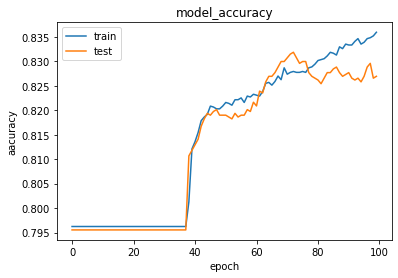

0.8435


In [1]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt

Churn_dataset = pd.read_csv("Churn.csv")
Churn_dataset.head()

X = Churn_dataset.iloc[:,:13]
Y = Churn_dataset.iloc[:,13]

Geography = pd.get_dummies(X['Geography'],drop_first = True)
Gender = pd.get_dummies(X['Gender'],drop_first = True)

X = pd.concat([X,Geography,Gender],axis = 1)

from sklearn.model_selection import train_test_split
X = X.drop(['Surname','CustomerId','RowNumber','Geography','Gender'],axis = 1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 0)

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Embedding,Flatten,BatchNormalization
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

## Initializing the ANN
classifier = Sequential()

## Adding the Input layer and the first hidden Layer
classifier.add(Dense(units = 6, kernel_initializer = "he_uniform", activation = "relu", input_dim = 11))

## Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = "he_uniform", activation = "relu"))

## Adding the Output Layer
classifier.add(Dense(units = 1, kernel_initializer = "glorot_uniform", activation = "sigmoid"))

## Compiling the ANN
classifier.compile(optimizer = "Adamax", loss = "binary_crossentropy",metrics = ["accuracy"])

### Fitting the ANN to the training set 
model_history = classifier.fit(X_train,Y_train,validation_split = 0.33,batch_size = 10,epochs=  100)


## List all data in history
print(model_history.history.keys())

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title("model_accuracy")
plt.ylabel("aacuracy")
plt.xlabel("epoch")
plt.legend(['train','test'], loc="upper left")
plt.show()


### Predicting the Model
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

### Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,y_pred)

### Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,Y_test)
print(accuracy)



In [2]:
####### Hyper Parameters ######
print(X_train.shape[1])

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(layers, activation):
  model = Sequential()
  for i, nodes in enumerate(layers):
    if i == 0:
      model.add(Dense(nodes,input_dim = X_train.shape[1]))
      model.add(Activation(activation))
      model.add(Dropout(0.3))
    else:
      model.add(Dense(nodes))
      model.add(Activation(activation))
      model.add(Dropout(0.3))

  model.add(Dense(units = 1,kernel_initializer="glorot_uniform",activation="sigmoid"))  

  model.compile(optimizer = "adam", loss = "binary_crossentropy",metrics = ["accuracy"])    
  return model


model = KerasClassifier(create_model,verbose = 0)

layers = [(20,), (40, 20), (45, 30, 15)]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid)


grid_result = grid.fit(X_train, Y_train)

print(grid_result.best_score_,grid_result.best_params_)

pred_y = grid.predict(X_test)
y_pred = (pred_y > 0.5)

### Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,y_pred)

### Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,Y_test)
print(accuracy)


11
0.8543749928474427 {'activation': 'relu', 'batch_size': 128, 'epochs': 30, 'layers': (45, 30, 15)}
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.8615


In [5]:
##Hyper Parameter using KerasTuner
!pip install -q -U keras-tuner
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

Churn_dataset = pd.read_csv("Churn.csv")
Churn_dataset.head()

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))### For Regression linear 
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])### For Regression mean absolute error
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',### For Regression mean absolute error
    max_trials=5,
    executions_per_trial=3,
    project_name='Churn Dataset')    

tuner.search_space_summary()

tuner.search(X_train, Y_train,
             epochs=10,
             validation_data=(X_test, Y_test))

INFO:tensorflow:Reloading Oracle from existing project ./Churn Dataset/oracle.json
INFO:tensorflow:Reloading Tuner from ./Churn Dataset/tuner0.json


INFO:tensorflow:Oracle triggered exit


In [6]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [7]:
pred_y = best_model.predict(X_test)
y_pred = (pred_y > 0.5)

### Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,y_pred)

### Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,Y_test)
print(accuracy)

0.869


In [8]:
best_model.save("model.h5")